# 2.1 KOH1: The basic Kohonen network
Implement a Kohonen network composed of neurons in an M×N rectangular grid (M,N are program parameters) that works for a set of vectors (all of the same length).

Implement the following neighborhood functions:
* Gaussian function.
* minus the second derivative of the Gaussian function.


In both implementations, add the ability to change the width of the neighborhood with a parameter (technically, this means multiplying the argument x by a constant) and check for several values in the interval [0.1,1].

Use α(t)=e-t/λ as a function that extinguishes learning with successive iterations.

Test the performance of the network on the provided simple datasets:
* 2d data clustered at the vertices of a hexagon,
* 3d data clustered at the vertices of a cube.

The data, hexagon and cube, respectively, have 3/4 columns. For the grid, specify only the x, y and z columns (in the case of the hexagon without z). The last column, c, contains the vertex identifier of the solid/figure.

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import homogeneity_score, completeness_score
from matplotlib import pyplot as plt
import plotly.express as px

In [4]:
 def euclid(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

def gauss(x, d):
    return np.exp(-np.square(x * d))

def gauss_bis(x, d):
    return (2 - 4 * np.square(x)) * np.exp(-np.square(x * d))

def alpha(t, epochs):
    return np.exp(-t/epochs)

def best_matching_unit(x, weights):
    dists = np.sum((weights - x)**2, axis=tuple(range(2, len(x.shape)+2)))
    return np.unravel_index(np.argmin(dists), dists.shape[:2])

#### SOM

In [5]:
def train(data, epochs, lr, d_neighbour, N, M, metric='gaussian'):
    weights = np.random.randn(N, M, data.shape[1])
    if metric == 'gaussian':
        metric = gauss
    elif metric == 'mexican hat':
        metric = gauss_bis
    
    for epoch in range(epochs):
        perm = np.random.permutation(data.shape[0])
        for x in data[perm]:
            BMU = best_matching_unit(x, weights)
            for n in range(N):
                for m in range(M):
                    distance = euclid(BMU, (n, m))
                    if d_neighbour >= distance:
                        delta = metric(distance, d_neighbour)
                        weights[n, m, :] += delta * (x - weights[n, m, :]) * lr
        lr *= alpha(epoch, epochs)
        d_neighbour *= alpha(epoch, epochs)
    weights = np.concatenate(weights)
    return weights

def predict(data, weights):
    return [np.argmin([euclid(w, x) for w in weights]) for x in data]

#### Examples
##### hexagon
gaussian

In [10]:
hexagon_df = pd.read_csv('../data/SOM/hexagon.csv')
x = np.asarray(hexagon_df.iloc[:, [0, 1]])
weights = train(x, epochs=20, lr=0.1, d_neighbour=0.5, N=2, M=3)
predictions = predict(x, weights)


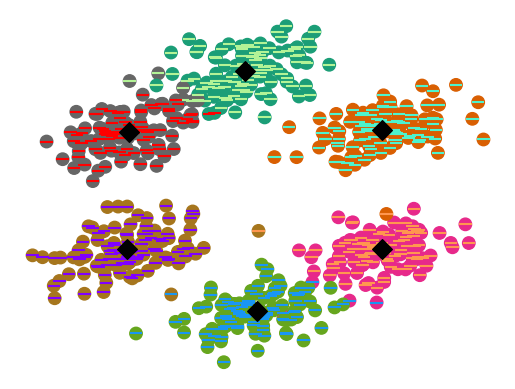

Metrics:
homogeneity_score: 0.9382229826187752
completeness_score: 0.9385095807845504
V-measure (Normalised Mutual Information): 0.9383662598182815
Number of clusters: 6


In [11]:
plt.scatter(hexagon_df['x'], hexagon_df['y'], c=hexagon_df['c'], cmap="Dark2", s=80)
plt.scatter(hexagon_df['x'], hexagon_df['y'], marker='_', c=predictions, cmap='rainbow', s=80)
plt.scatter(weights[:,0], weights[:,1], marker='D', c='black', s = 100)
plt.axis('off')
plt.show()

homogeneity = homogeneity_score(hexagon_df['c'], predictions)
completeness = completeness_score(hexagon_df['c'], predictions)
print(f'Metrics:\nhomogeneity_score: {homogeneity}\ncompleteness_score: {completeness}\nV-measure (Normalised Mutual Information): {2*homogeneity*completeness/(homogeneity + completeness)}')
print(f'Number of clusters: {len(np.unique(predictions))}')

mexican hat

In [135]:
hexagon_df = pd.read_csv('../data/SOM/hexagon.csv')
x = np.asarray(hexagon_df.iloc[:, [0, 1]])
weights = train(x, epochs=10, lr=0.1, d_neighbour=0.9, N=2, M=3, metric='mexican hat')
predictions = predict(x, weights)

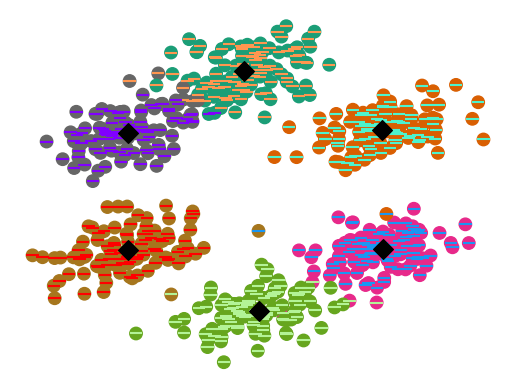

Metrics:
homogeneity_score: 0.9382229826187753
completeness_score: 0.9385095807845504
V-measure (Normalised Mutual Information): 0.9383662598182815
Number of clusters: 6


In [131]:
plt.scatter(hexagon_df['x'], hexagon_df['y'], c=hexagon_df['c'], cmap="Dark2", s=80)
plt.scatter(hexagon_df['x'], hexagon_df['y'], marker='_', c=predictions, cmap='rainbow', s=80)
plt.scatter(weights[:,0], weights[:,1], marker='D', c='black', s = 100)
plt.axis('off')
plt.show()

homogeneity = homogeneity_score(hexagon_df['c'], predictions)
completeness = completeness_score(hexagon_df['c'], predictions)
print(f'Metrics:\nhomogeneity_score: {homogeneity}\ncompleteness_score: {completeness}\nV-measure (Normalised Mutual Information): {2*homogeneity*completeness/(homogeneity + completeness)}')
print(f'Number of clusters: {len(np.unique(predictions))}')

gaussian vs mexican hat

different distances between neighbours

In [136]:
weights = []
predictions = []
homogeneity = []
completeness = []
v_measure = []
lrs = np.arange(0.05, 1.05, 0.05)
for i in range(0, 20):
    weights.append(train(x, epochs=20, lr=0.01, d_neighbour=lrs[i], N=2, M=3, metric='mexican hat'))
    predictions.append(predict(x, weights[i]))
    homogeneity.append(homogeneity_score(hexagon_df['c'], predictions[i]))
    completeness.append(completeness_score(hexagon_df['c'], predictions[i]))
    v_measure.append(2*homogeneity[i]*completeness[i]/(homogeneity[i] + completeness[i]))

In [137]:
weights2 = []
predictions2 = []
homogeneity2 = []
completeness2 = []
v_measure2 = []
lrs2 = np.arange(0.05, 1.05, 0.05)
for i in range(0, 20):
    weights2.append(train(x, epochs=20, lr=0.01, d_neighbour=lrs2[i], N=2, M=3, metric='gaussian'))
    predictions2.append(predict(x, weights2[i]))
    homogeneity2.append(homogeneity_score(hexagon_df['c'], predictions2[i]))
    completeness2.append(completeness_score(hexagon_df['c'], predictions2[i]))
    v_measure2.append(2*homogeneity2[i]*completeness2[i]/(homogeneity2[i] + completeness2[i]))

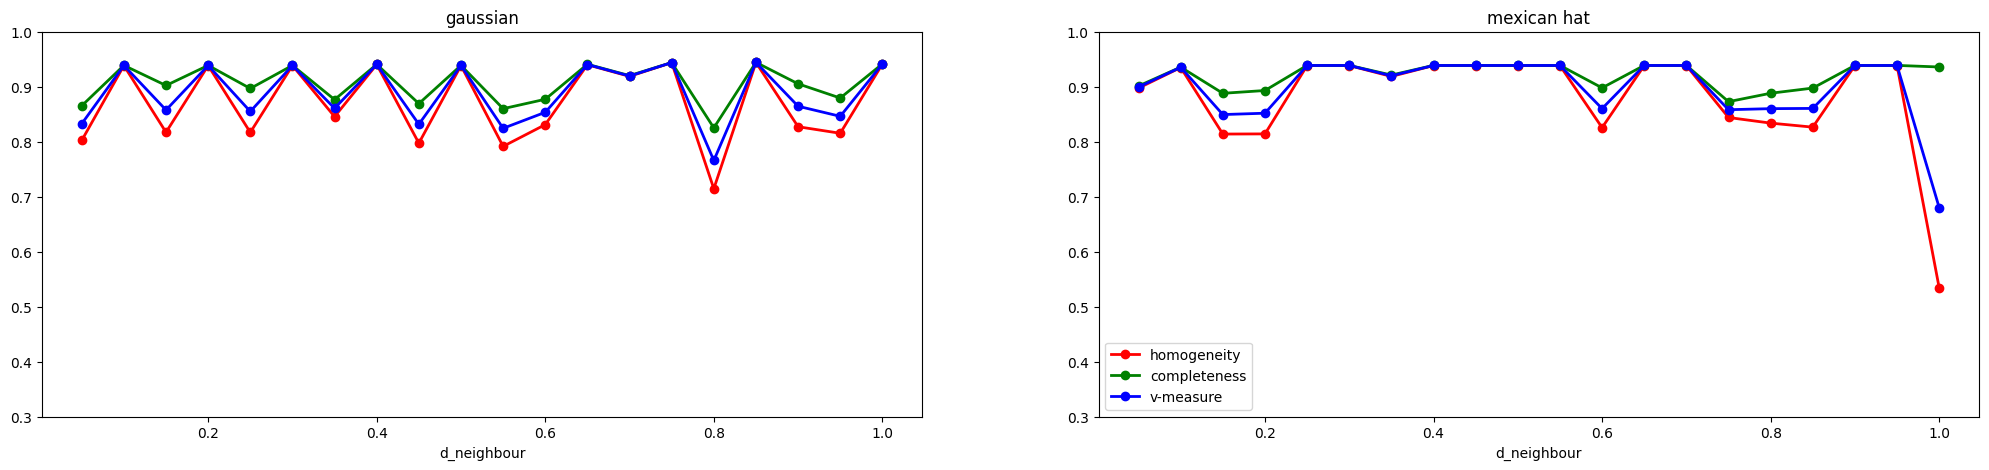

In [138]:
plt.subplots(1, 2, figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.plot(lrs, homogeneity2, color='red', marker='o', linewidth=2, label='homogeneity')
plt.plot(lrs, completeness2, color='green', marker='o', linewidth=2, label='completeness')
plt.plot(lrs, v_measure2, color='blue', marker='o', linewidth=2, label='v-measure')
plt.ylim([0.3, 1])
plt.xlabel('d_neighbour')
plt.title("gaussian")
plt.subplot(1, 2, 2)
plt.plot(lrs, homogeneity, color='red', marker='o', linewidth=2, label='homogeneity')
plt.plot(lrs, completeness, color='green', marker='o', linewidth=2, label='completeness')
plt.plot(lrs, v_measure, color='blue', marker='o', linewidth=2, label='v-measure')
plt.ylim([0.3, 1])
plt.xlabel('d_neighbour')
plt.title("mexican hat")
plt.legend()
plt.show()

##### cube

In [132]:
cube_df = pd.read_csv('../data/SOM/cube.csv')
x = np.asarray(cube_df.iloc[:, 0:3])
weights = train(x, epochs=20, lr=0.1, d_neighbour=1, N=4, M=2)
predictions = predict(x, weights)

Metrics:
homogeneity_score: 0.9213143845926394
completeness_score: 0.9215092480585411
V-measure (Normalised Mutual Information): 0.9214118060229846
Number of clusters:
real: 8
predicted: 8


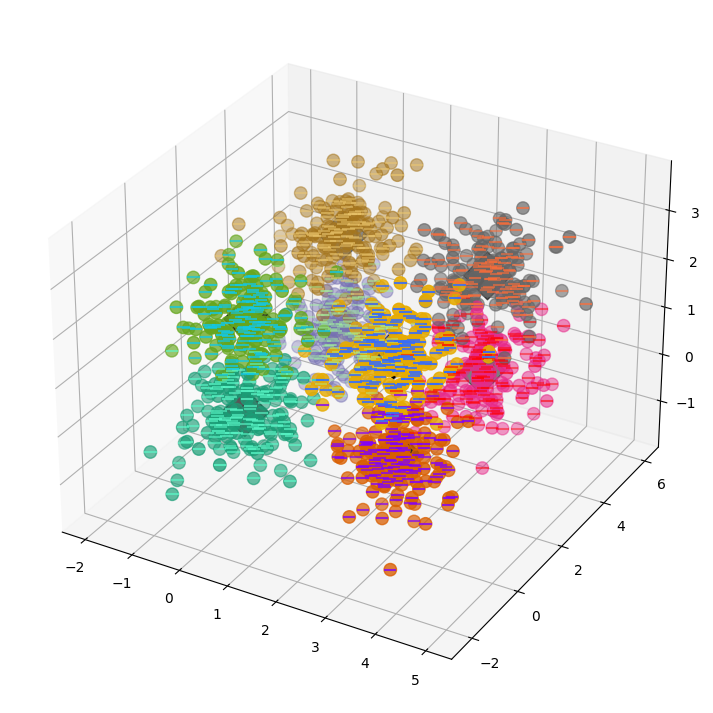

In [133]:
fig = plt.figure(figsize = (18, 9))
ax = plt.axes(projection='3d')
ax.scatter(cube_df['x'], cube_df['y'], cube_df['z'], c=cube_df['c'], cmap='Dark2', s=80)
ax.scatter(cube_df['x'], cube_df['y'], cube_df['z'], c=predictions, marker = '_', cmap='rainbow', s=80)
ax.scatter(weights[:,0], weights[:,1], weights[:,2], marker='D', c='black', s= 600)

homogeneity = homogeneity_score(cube_df['c'], predictions)
completeness = completeness_score(cube_df['c'], predictions)
print(f'Metrics:\nhomogeneity_score: {homogeneity}\ncompleteness_score: {completeness}\nV-measure (Normalised Mutual Information): {2*homogeneity*completeness/(homogeneity + completeness)}')
print(f'Number of clusters:\nreal: {len(np.unique(cube_df["c"]))}\npredicted: {len(np.unique(predictions))}')

In [8]:
fig = px.scatter_3d(cube_df, x='x', y='y', z='z', color='c', symbol=predictions, size=[5]*len(cube_df['z']), opacity=0.6)
fig.update(layout_showlegend=False) 
fig.show()

gaussian vs mexican hat

different distances between neighbours

In [106]:
weights = []
predictions = []
homogeneity = []
completeness = []
v_measure = []
lrs = np.arange(0.05, 1.05, 0.05)
for i in range(0, 20):
    weights.append(train(x, epochs=20, lr=0.1, d_neighbour=lrs[i], N=4, M=2, metric='mexican hat'))
    predictions.append(predict(x, weights[i]))
    homogeneity.append(homogeneity_score(hexagon_df['c'], predictions[i]))
    completeness.append(completeness_score(hexagon_df['c'], predictions[i]))
    v_measure.append(2*homogeneity[i]*completeness[i]/(homogeneity[i] + completeness[i]))

In [107]:
weights2 = []
predictions2 = []
homogeneity2 = []
completeness2 = []
v_measure2 = []
lrs2 = np.arange(0.05, 1.05, 0.05)
for i in range(0, 20):
    weights2.append(train(x, epochs=20, lr=0.1, d_neighbour=lrs2[i], N=4, M=2, metric='gaussian'))
    predictions2.append(predict(x, weights2[i]))
    homogeneity2.append(homogeneity_score(hexagon_df['c'], predictions2[i]))
    completeness2.append(completeness_score(hexagon_df['c'], predictions2[i]))
    v_measure2.append(2*homogeneity2[i]*completeness2[i]/(homogeneity2[i] + completeness2[i]))

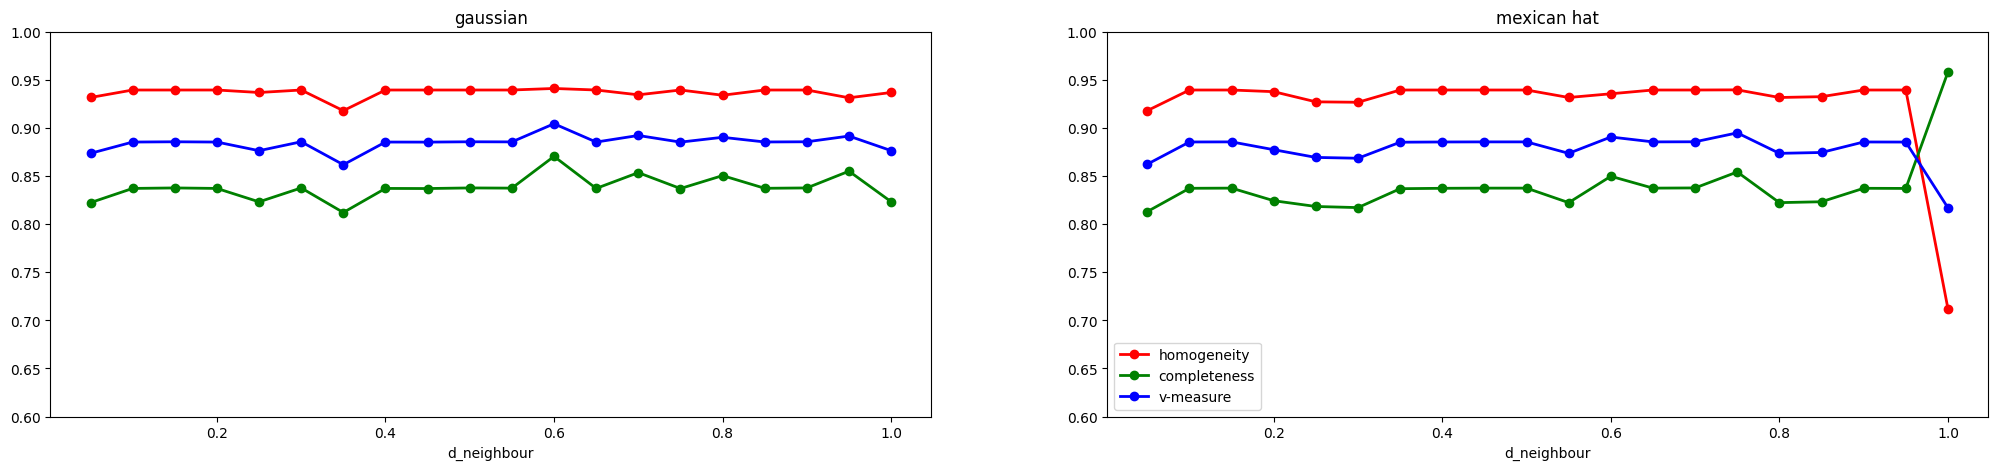

In [109]:
plt.subplots(1, 2, figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.plot(lrs, homogeneity2, color='red', marker='o', linewidth=2, label='homogeneity')
plt.plot(lrs, completeness2, color='green', marker='o', linewidth=2, label='completeness')
plt.plot(lrs, v_measure2, color='blue', marker='o', linewidth=2, label='v-measure')
plt.ylim([0.6, 1])
plt.xlabel('d_neighbour')
plt.title("gaussian")
plt.subplot(1, 2, 2)
plt.plot(lrs, homogeneity, color='red', marker='o', linewidth=2, label='homogeneity')
plt.plot(lrs, completeness, color='green', marker='o', linewidth=2, label='completeness')
plt.plot(lrs, v_measure, color='blue', marker='o', linewidth=2, label='v-measure')
plt.ylim([0.6, 1])
plt.xlabel('d_neighbour')
plt.title("mexican hat")
plt.legend()
plt.show()